In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8676981999596532088
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6940786688
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9304301400475051744
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
print(tf.__version__)

2.8.0


In [6]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
train_path="small/train"
test_path="small/test"
val_path="small/val"


In [8]:
(height, width, channels) = (80, 48, 3)

x_train=[]

for folder in os.listdir(train_path):

    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(height, width))

        x_train.append(img_arr)

x_test=[]

for folder in os.listdir(test_path):

    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(height, width))

        x_test.append(img_arr)
        
x_val=[]

for folder in os.listdir(val_path):

    sub_path=val_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(height, width))

        x_val.append(img_arr)



In [9]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0





In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

val_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (height, width),
                                                 batch_size = 32,
                                                 class_mode = 'sparse',
                                                 color_mode="grayscale"
                                                )
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (height, width),
                                            batch_size = 32,
                                            class_mode = 'sparse',
                                            color_mode="grayscale")
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (height, width),
                                            batch_size = 32,
                                            class_mode = 'sparse',
                                            color_mode="grayscale")

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 1900 images belonging to 7 classes.


In [13]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [14]:
#training_set.class_indices
train_y.shape,test_y.shape,val_y.shape


((28709,), (7178,), (1900,))

In [15]:
IMAGE_SIZE = [48,80]

In [16]:
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


In [17]:
for layer in vgg.layers:
    layer.trainable = False

In [18]:
x = Flatten()(vgg.output)


In [19]:
prediction = Dense(7, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs= prediction)

In [20]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 80, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 80, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 80, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 40, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 40, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 40, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 20, 128)       0     

In [21]:
model.compile(
  tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=4)

In [23]:
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=50,
  callbacks=[early_stop],
  batch_size=64,shuffle=True)

Epoch 1/50
449/449 [==============================] - 18s 36ms/step - loss: 1.6707 - accuracy: 0.3414 - val_loss: 2.0221 - val_accuracy: 0.2953
Epoch 2/50
449/449 [==============================] - 15s 34ms/step - loss: 1.5769 - accuracy: 0.3880 - val_loss: 1.9059 - val_accuracy: 0.3200
Epoch 3/50
449/449 [==============================] - 15s 34ms/step - loss: 1.5451 - accuracy: 0.4024 - val_loss: 1.8622 - val_accuracy: 0.3268
Epoch 4/50
449/449 [==============================] - 15s 34ms/step - loss: 1.5245 - accuracy: 0.4099 - val_loss: 1.7911 - val_accuracy: 0.3358
Epoch 5/50
449/449 [==============================] - 15s 34ms/step - loss: 1.5102 - accuracy: 0.4179 - val_loss: 1.7838 - val_accuracy: 0.3400
Epoch 6/50
449/449 [==============================] - 15s 34ms/step - loss: 1.5003 - accuracy: 0.4242 - val_loss: 1.7998 - val_accuracy: 0.3358
Epoch 7/50
449/449 [==============================] - 15s 34ms/step - loss: 1.4882 - accuracy: 0.4270 - val_loss: 1.8103 - val_accuracy:

In [24]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [26]:
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

In [27]:
print(classification_report(y_pred,test_y,zero_division=0))


              precision    recall  f1-score   support

           0       0.27      0.34      0.30       746
           1       0.04      0.44      0.07         9
           2       0.29      0.29      0.29      1029
           3       0.65      0.48      0.55      2405
           4       0.32      0.40      0.36      1009
           5       0.38      0.33      0.35      1434
           6       0.42      0.63      0.50       546

    accuracy                           0.41      7178
   macro avg       0.34      0.42      0.34      7178
weighted avg       0.44      0.41      0.42      7178



In [28]:
confusion_matrix_=confusion_matrix(y_pred,test_y)


In [29]:
confusion_matrix_

array([[ 255,   17,   99,  109,  109,  110,   47],
       [   1,    4,    2,    0,    1,    1,    0],
       [ 114,   29,  294,  114,  141,  157,  180],
       [ 235,   34,  199, 1151,  326,  336,  124],
       [ 127,    6,  102,  140,  399,  153,   82],
       [ 193,   19,  238,  230,  231,  471,   52],
       [  33,    2,   90,   30,   26,   19,  346]], dtype=int64)

In [31]:
import seaborn as sb
from matplotlib.colors import LogNorm, PowerNorm


Confusion Matrix


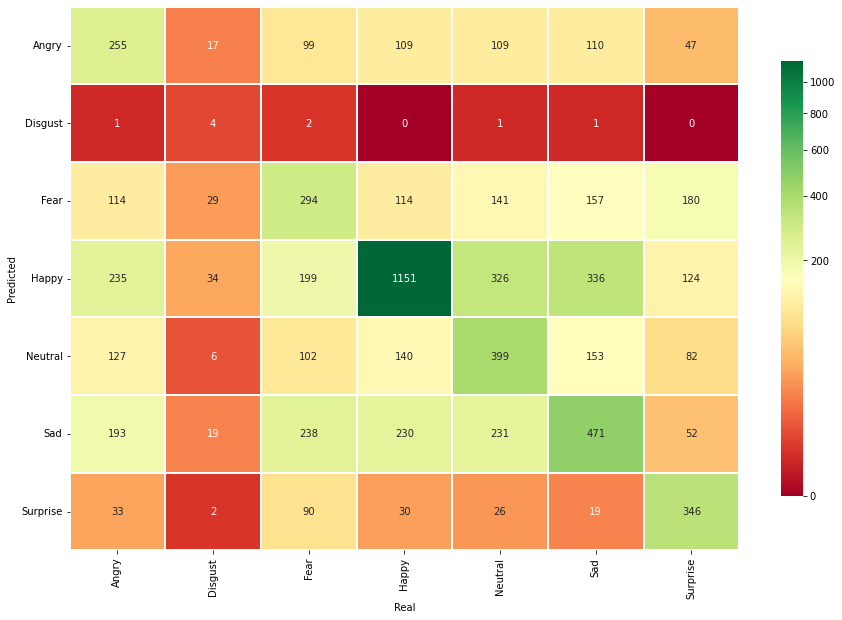

In [32]:
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad','Surprise']
positions = list(range(len(labels)))
positions = [x+0.5 for x in positions]

print(f'Confusion Matrix')
fig, ax = plt.subplots(figsize=(15, 10))
# plot heatmap
sb.heatmap(confusion_matrix_,
           cmap='RdYlGn',
           annot=True,
           fmt="1d",
           linewidth=0.3,
           cbar_kws={"shrink": .8},
           norm=PowerNorm(vmin=confusion_matrix_.min().min(),
                          vmax=confusion_matrix_.max().max(),
                          gamma=0.35)
          )

plt.xlabel('Real')
ax.set_xticks(positions, labels, rotation = 90)
plt.ylabel('Predicted')
ax.set_yticks(positions, labels, rotation = 0)
plt.show()